In [1]:
import ee
import geemap
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import geopandas as gpd
import pandas as pd
from shapely.geometry import box
import zipfile
import contextlib
from sklearn.cluster import KMeans
import contextily as cnx

In [2]:
ee.Initialize()

## Splitting polygon data into train, validation and test

In [3]:
def split_data(gdf):
    """
        Function to split both datasets into train, validation and test spatially. The function uses K-Means clustering with x, y coordinates to split the data in groups of polygons roughly as (60% Training, 20% Validation and 20% Test.)

        Input:
            - gdf: GeoDataFrame with the complete dataset.

        Output:
            - gdf: GeoDataFrame with an additional feature ('split') with the split to which the polygon belongs (Train, Validation or Test).
    """
    gdf.geometry = gdf.make_valid()

    # Get centroids 
    centroids = pd.DataFrame([gdf.centroid.x, gdf.centroid.y]).T

    # Get the clusters with K-Means.
    kmeans = KMeans(10, random_state = 10)
    labels = kmeans.fit_predict(centroids)

    gdf['split'] = 'train' # Roughly 60% of the data
    gdf['split'][labels > 5] = 'validation' # Roughly 20% of the data
    gdf['split'][labels > 7] = 'test' # Roughly 20% of the data

    return gdf

### For Tanzania

In [4]:
TNZ_Csh = gpd.read_file('../Data/Vector/Cashew_Tanzania.shp')
TNZ_Csh = TNZ_Csh[['LU', 'geometry']]

TNZ_Csh = split_data(TNZ_Csh)

C:\Users\mdomi\AppData\Local\Temp\ipykernel_28848\3610417536.py:14: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = pd.DataFrame([gdf.centroid.x, gdf.centroid.y]).T
C:\Users\mdomi\miniconda3\envs\mgi\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\mdomi\miniconda3\envs\mgi\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\mdomi\AppData\Local\Temp\ipykernel_28848\3610417536.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

In [5]:
TNZ_Csh.to_crs('EPSG:32736').dissolve('split').area/sum(TNZ_Csh.to_crs('EPSG:32736').area)

split
test          0.159924
train         0.576698
validation    0.263378
dtype: float64

In [6]:
TNZ_Csh.to_file('../Data/Vector/Cashew_Polygons_TNZ_splitted_KM.geojson')

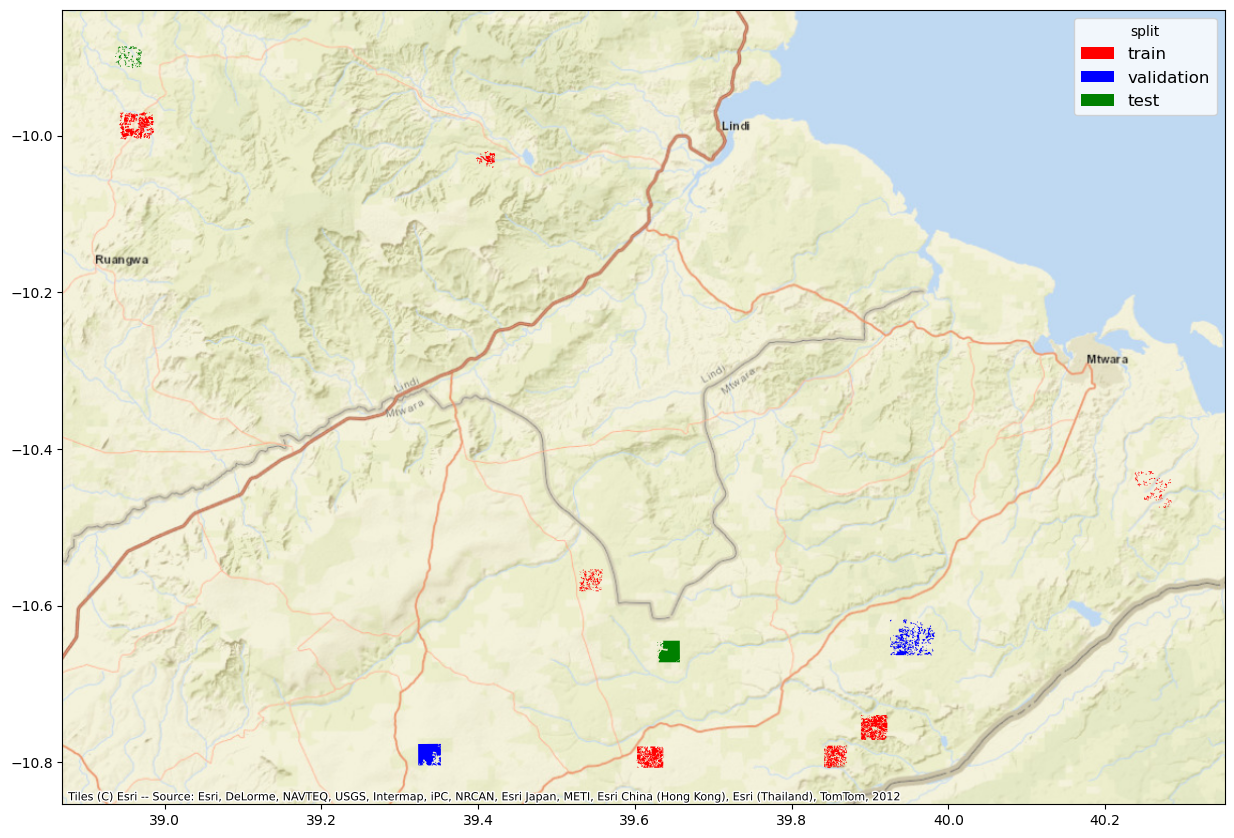

In [7]:
fig, ax = plt.subplots(1,1, figsize = (15,15))

col = {'train' : 'red', 'validation' : 'blue', 'test' : 'green'}

TNZ_Csh.plot(
    # column = 'split',
             # palette = ['red', 'blue', 'green'],
             color = [col[i] for i in TNZ_Csh['split']],
             legend = True, 
             ax = ax)

legend_elements = [Patch(facecolor='red', label='Color Patch'),
                   Patch(facecolor='blue', label='Color Patch'),
                   Patch(facecolor='green', label='Color Patch')]

ax.legend(legend_elements, 
          ['train', 'validation', 'test'], 
          fontsize = 12,
          title  = 'split',
          loc = 'upper right')

cnx.add_basemap(ax = ax, 
                crs = TNZ_Csh.crs, 
                source = cnx.providers.Esri.WorldStreetMap)

fig.savefig('../imgs/SplitSet_Tanzania.png')

### For Ivory Coast

In [8]:
CIV_Csh = gpd.read_file('../Data/Vector/Cashew_Ivorycoast.shp')
CIV_Csh = CIV_Csh.explode()

CIV_Csh = split_data(CIV_Csh)

C:\Users\mdomi\AppData\Local\Temp\ipykernel_28848\1481210275.py:2: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  CIV_Csh = CIV_Csh.explode()
C:\Users\mdomi\AppData\Local\Temp\ipykernel_28848\3610417536.py:14: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = pd.DataFrame([gdf.centroid.x, gdf.centroid.y]).T
C:\Users\mdomi\miniconda3\envs\mgi\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\mdomi\AppData\Local\Temp\ipykernel_28848\3610417536.py:21: SettingWithCopyWarning: 
A value is trying to be set

In [9]:
CIV_Csh.to_crs('EPSG:2041').dissolve('split').area/sum(CIV_Csh.to_crs('EPSG:2041').area)

split
test          0.089476
train         0.780292
validation    0.130232
dtype: float64

In [10]:
CIV_Csh.to_file('../Data/Vector/Cashew_Polygons_CIV_splitted_KM.geojson')

C:\Users\mdomi\AppData\Local\Temp\ipykernel_28848\2265051218.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sns.kdeplot(x = CIV_Csh.centroid.x, y = CIV_Csh.centroid.y,


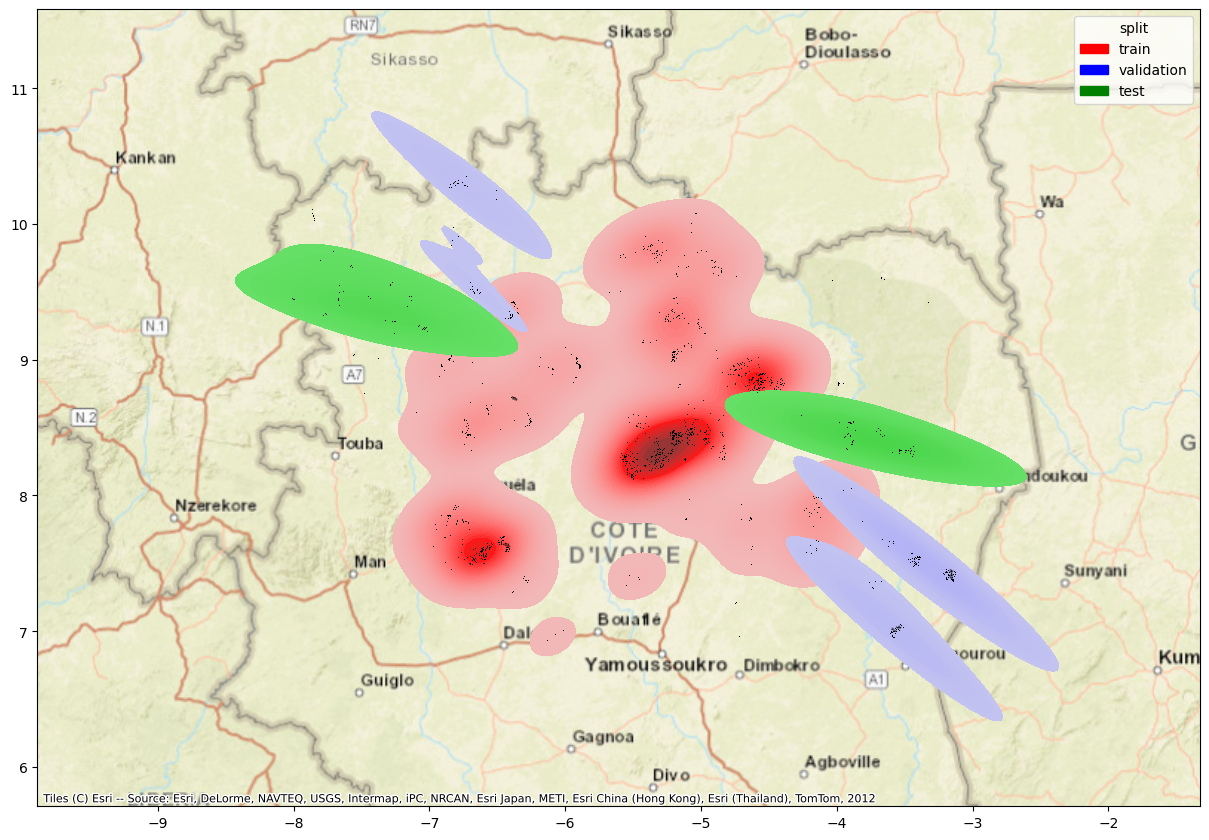

In [11]:
fig, ax = plt.subplots(1,1, figsize = (15,15))

sns.kdeplot(x = CIV_Csh.centroid.x, y = CIV_Csh.centroid.y,
            hue = CIV_Csh.split, thresh = 0.1, 
            fill = True, levels = 40, 
            palette = ['red', 'blue', 'green'])

CIV_Csh.plot(legend = True, ax = ax, color = 'k')

cnx.add_basemap(ax = ax, 
                crs = CIV_Csh.crs, 
                source = cnx.providers.Esri.WorldStreetMap)

fig.savefig('../imgs/SplitSet_Ivorpng')

# Download the data for the different splits

In [12]:
params = pd.read_table('Track_params.txt', delimiter = ', ')

for i in range(len(params)):
    globals()[params['Param'].iloc[i]] = params['value'].iloc[i]

C:\Users\mdomi\AppData\Local\Temp\ipykernel_28848\2511713476.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  params = pd.read_table('Track_params.txt', delimiter = ', ')


In [13]:
Pl = (ee.ImageCollection(platform)
      .filterDate(date_beg, date_end)
      .select(['B','G','R','N'])
      )

img = Pl.median()

# vis_params = {"min": 0, "max": 2000, "bands": ["R", "G", "B"]}

# Map = geemap.Map(zoom = 4)

# Map.addLayer(ee.Image(img), vis_params, "NICFI")

# Map

In [14]:
def download_ee_image(gdf, epsg, out_fn, img, dir_name = '../Data/Planet/', chunks = 2, start = 1):
    """
        Function to download a google earth engine image using geemap. It divides the image in chunks usin K-Means clustering in the geodataframe used to crop the images with a buffer of 2km. 
    """
    kmeans = KMeans(chunks, random_state = 10)

    # for i in os.listdir(dir_name):
    #     if out_fn in i:
    #         os.remove(dir_name+i)

    centroids = pd.DataFrame([gdf.centroid.x, gdf.centroid.y]).T

    labels = kmeans.fit_predict(centroids)

    for i in np.arange(start - 1, len(np.unique(labels)), 1):
        
        aoi = geemap.geopandas_to_ee(gdf[labels == i])
    
        bound = aoi.geometry().buffer(2000)
        
        Pl_gdf = img.clip(bound)
    
        geemap.download_ee_image(ee.Image(Pl_gdf).setDefaultProjection(epsg), dir_name + out_fn + str(i+1) + '.tif', crs = epsg, scale = 4.77)

## For Tanzania

### Train split

In [20]:
with contextlib.suppress(PermissionError):
    download_ee_image(TNZ_Csh[TNZ_Csh['split'] == 'train'], 'EPSG:32736', 'TanzaniaTrainStudyArea', img, chunks = 4)

C:\Users\mdomi\AppData\Local\Temp\ipykernel_27496\210835465.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = pd.DataFrame([gdf.centroid.x, gdf.centroid.y]).T
C:\Users\mdomi\miniconda3\envs\mgi\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\mdomi\miniconda3\envs\mgi\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


TanzaniaTrainStudyArea1.tif: |                                         | 0.00/700M (raw) [  0.0%] in 00:00 (et…

TanzaniaTrainStudyArea2.tif: |                                         | 0.00/211M (raw) [  0.0%] in 00:00 (et…

Consider adjusting `region`, `scale` and/or `dtype` to reduce the TanzaniaTrainStudyArea3.tif download size (raw: 1.03 GB).


TanzaniaTrainStudyArea3.tif: |                                        | 0.00/1.03G (raw) [  0.0%] in 00:00 (et…

TanzaniaTrainStudyArea4.tif: |                                         | 0.00/121M (raw) [  0.0%] in 00:00 (et…

### Validation split

In [16]:
with contextlib.suppress(PermissionError):
    download_ee_image(TNZ_Csh[TNZ_Csh['split'] == 'validation'], 'EPSG:32736', 'TanzaniaValidationStudyArea', img)

C:\Users\mdomi\AppData\Local\Temp\ipykernel_27496\210835465.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = pd.DataFrame([gdf.centroid.x, gdf.centroid.y]).T
C:\Users\mdomi\miniconda3\envs\mgi\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\mdomi\miniconda3\envs\mgi\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


TanzaniaValidationStudyArea1.tif: |                                    | 0.00/135M (raw) [  0.0%] in 00:00 (et…

There is no STAC entry for: None


TanzaniaValidationStudyArea2.tif: |                                   | 0.00/72.9M (raw) [  0.0%] in 00:00 (et…

### Test split

In [17]:
with contextlib.suppress(PermissionError):
    download_ee_image(TNZ_Csh[TNZ_Csh['split'] == 'test'], 'EPSG:32736', 'TanzaniaTestStudyArea', img)

C:\Users\mdomi\AppData\Local\Temp\ipykernel_27496\210835465.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = pd.DataFrame([gdf.centroid.x, gdf.centroid.y]).T
C:\Users\mdomi\miniconda3\envs\mgi\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\mdomi\miniconda3\envs\mgi\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


TanzaniaTestStudyArea1.tif: |                                         | 0.00/78.4M (raw) [  0.0%] in 00:00 (et…

TanzaniaTestStudyArea2.tif: |                                         | 0.00/72.8M (raw) [  0.0%] in 00:00 (et…

## For Ivory Coast

### All CIV

In [ ]:
with contextlib.suppress(PermissionError):
    download_ee_image(CIV_Csh[CIV_Csh['split'] == 'train'], 'EPSG:2041', 'IvoryCoastStudyArea', img,  chunks = 4)

C:\Users\mdomi\AppData\Local\Temp\ipykernel_27496\210835465.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = pd.DataFrame([gdf.centroid.x, gdf.centroid.y]).T
C:\Users\mdomi\miniconda3\envs\mgi\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Consider adjusting `region`, `scale` and/or `dtype` to reduce the IvoryCoastStudyArea1.tif download size (raw: 52.48 GB).


IvoryCoastStudyArea1.tif: |                                           | 0.00/52.5G (raw) [  0.0%] in 00:00 (et…

### Train split

In [15]:
with contextlib.suppress(PermissionError):
    download_ee_image(CIV_Csh[CIV_Csh['split'] == 'train'], 'EPSG:2041', 'IvoryCoastTrainStudyArea', img, chunks = 15, start = 11)

C:\Users\mdomi\AppData\Local\Temp\ipykernel_28848\2020812822.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = pd.DataFrame([gdf.centroid.x, gdf.centroid.y]).T
C:\Users\mdomi\miniconda3\envs\mgi\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Consider adjusting `region`, `scale` and/or `dtype` to reduce the IvoryCoastTrainStudyArea11.tif download size (raw: 12.16 GB).


IvoryCoastTrainStudyArea11.tif: |                                     | 0.00/12.2G (raw) [  0.0%] in 00:00 (et…

There is no STAC entry for: None
Consider adjusting `region`, `scale` and/or `dtype` to reduce the IvoryCoastTrainStudyArea12.tif download size (raw: 6.27 GB).


IvoryCoastTrainStudyArea12.tif: |                                     | 0.00/6.27G (raw) [  0.0%] in 00:00 (et…

Consider adjusting `region`, `scale` and/or `dtype` to reduce the IvoryCoastTrainStudyArea13.tif download size (raw: 2.03 GB).


IvoryCoastTrainStudyArea13.tif: |                                     | 0.00/2.03G (raw) [  0.0%] in 00:00 (et…

Consider adjusting `region`, `scale` and/or `dtype` to reduce the IvoryCoastTrainStudyArea14.tif download size (raw: 16.69 GB).


IvoryCoastTrainStudyArea14.tif: |                                     | 0.00/16.7G (raw) [  0.0%] in 00:00 (et…

Consider adjusting `region`, `scale` and/or `dtype` to reduce the IvoryCoastTrainStudyArea15.tif download size (raw: 6.24 GB).


IvoryCoastTrainStudyArea15.tif: |                                     | 0.00/6.24G (raw) [  0.0%] in 00:00 (et…

### Validation split

In [17]:
with contextlib.suppress(Permissi onError):
    download_ee_image(CIV_Csh[CIV_Csh['split'] == 'validation'], 'EPSG:2041', 'IvoryCoastValidationStudyArea', img, chunks = 10, start = 8)

SyntaxError: invalid syntax. Perhaps you forgot a comma? (3233722268.py, line 1)

### Test split

In [ ]:
with contextlib.suppress(PermissionError):
    download_ee_image(CIV_Csh[CIV_Csh['split'] == 'test'], 'EPSG:2041', 'IvoryCoastTestStudyArea', img, chunks = 4, start = 2)

C:\Users\mdomi\AppData\Local\Temp\ipykernel_28848\2020812822.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = pd.DataFrame([gdf.centroid.x, gdf.centroid.y]).T
C:\Users\mdomi\miniconda3\envs\mgi\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\mdomi\miniconda3\envs\mgi\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
Consider adjusting `region`, `scale` and/or `dtype` to reduce the IvoryCoastTestStudyArea2.tif download size (raw: 14.46 GB).


IvoryCoastTestStudyArea2.tif: |                                       | 0.00/14.5G (raw) [  0.0%] in 00:00 (et…